# __Entregable__: Preprocesamiento de datos multivariados o de una serie temporal

Este es el entregable 1 preparado para el módulo de Estadística (Bloque 2) para la concentración de IA Avanzada<br>

Utilizando las variables explicativas y dependientes del modelo realizado en el entregable del Bloque 1. Las variables independientes deben ser razones financieras así como las variables dummy (0/1) de la variable de tamaño.

1. Realiza un análisis exploratorio de las variables:
    1. Calcula matriz de varianza y covarianza, así como matriz de correlación de las variables independientes y la dependiente. Explicar qué es la varianza, covarianza y correlación. Interpreta la matriz de correlación. Tiene que utilizar álgebra matricial y corroborar resultados con funciones de Python.
    2. Corre pruebas estadísticas para detectar outliers y leverage points. Tiene que utilizar álgebra matricial para las pruebas y explicar claramente cómo funcionan las pruebas. Puede utilizar funciones de Python para corroborar resultados.
2. Hace un análisis de multicolinealidad explicando la prueba e implicaciones en el modelo.
3. Propone e implementa soluciones a los problemas de los puntos anteriores para que el modelo sea el más adecuado.
4. Estima e interpreta un modelo de regresión múltiple después de atender los problemas anteriores. Tiene que utilizar álgebra matricial para estimar coeficientes y errores estándar del modelo de regresión, y utilizar funciones de Python para corroborar resultados.

In [1]:
# Data management module
import numpy as np
import pandas as pd

# Graph data
import seaborn as sns
import matplotlib.pyplot as plt

# Linear regression modules
import statsmodels.api as sm
from sklearn.metrics import r2_score
from statsmodels.formula.api import ols
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

# quit warnings
import warnings
warnings.filterwarnings("ignore")

# To show graphics in the notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

### __Análisis exploratorio de las variables__

In [2]:
# Open files and save them into a DataFrame
us = pd.read_csv('us2022q2a.csv')      # https://apradie.com/datos/us2022q2a.csv
firms = pd.read_csv('usfirms2022.csv') # https://apradie.com/datos/usfirms2022.csv
print(us.columns)    # Check columns in us data
print(firms.columns) # Check columns in firms data

Index(['firm', 'q', 'revenue', 'cogs', 'sgae', 'otheropexp', 'extraincome',
       'finexp', 'incometax', 'totalassets', 'totalliabilities', 'shortdebt',
       'longdebt', 'stockholderequity', 'adjprice', 'originalprice',
       'sharesoutstanding', 'fiscalmonth', 'year', 'cto'],
      dtype='object')
Index(['Ticker', 'Name', 'N', 'Class', 'Country\nof Origin', 'Type of Asset',
       'Sector NAICS\nlevel 1', 'Exchange / Src', 'Sector\nEconomatica',
       'Sector NAICS\nlast available', 'partind'],
      dtype='object')


In [3]:
# Merge us and firms data into us_firms 
us_firms = us.merge(firms, left_on='firm', right_on='Ticker')
# Drop useless columns
us_firms = us_firms.drop(['Sector\nEconomatica','Sector NAICS\nlast available','partind','N', 'year','Exchange / Src','Class','cto',
                          'Country\nof Origin','Type of Asset','Ticker', 'extraincome', 'fiscalmonth'], axis=1)
# Extract Financial services information
us_firms = us_firms[us_firms['Sector NAICS\nlevel 1'].isin(['Finance and Insurance', 'Real Estate and Rental and Leasing'])]
us_firms.head()

,firm,q,revenue,cogs,sgae,otheropexp,finexp,incometax,totalassets,totalliabilities,shortdebt,longdebt,stockholderequity,adjprice,originalprice,sharesoutstanding,Name,Sector NAICS\nlevel 1
180,AAIC,2000q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.840768,10.8750,NaN,Arlington Asset Investment Corp,Finance and Insurance
181,AAIC,2000q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.524712,8.1250,NaN,Arlington Asset Investment Corp,Finance and Insurance
182,AAIC,2000q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.547554,9.3125,NaN,Arlington Asset Investment Corp,Finance and Insurance
183,AAIC,2000q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.231498,6.5625,NaN,Arlington Asset Investment Corp,Finance and Insurance
184,AAIC,2001q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.564359,5.4800,NaN,Arlington Asset Investment Corp,Finance and Insurance


#### Get information that we need

  *__SELECT__*
- Variable calculations:
  - Firm size measures:
    + Book value of the firm = (totalassets-totalliabilities)
    + Market value = (originalprice * sharesoutstanding) -> (precio del stock histórico)
    <br>
  - Profit Margin measures:
    + OPM (Operating Profit Margin) = operating profit / sales = ebit / revenue
      * Operating profit = (revenue - cogs - sgae - otheropexp) = ebit or Ebit (Earning before Interst and Taxes)
      * Cogs = Cost of Good Sold -> __Variable cost__
      * Sgae = Sales and General Administrative Expenses -> __Fixed costs__
      <br>
    * Profit margin = Net income / (revenue = sales)<br>
    * Net income = ebit - incometax - finexp<br>
    * Income tax = what the firm pays in taxes (for the government)(impuesto sobre la renta)<br>
    * Finexp = financial expenses = what the firm pays in interest expenses for any loan that the firm issued<br>
<br>

- Dependet variable => Stock Annual Returns (cc.) 1 Quarter<br>
|----------------------- Later (F1r) -> returns shifted one<br>
Catalog (possible) Independent variables<br>
EPSP = EPS / StockPrice<br>
EPS = NetIncome / sharesoutstanding<br>

1. Sales annual growth = (revenue_t / revenue(t-4)) - 1
2. Operating profit growth
    Operating profit = EBIT (Earning Befora Interest and Taxes)
3. Operating profit margin = EBIT / revenue
4. Book-to-market ratio = book value / market value = (totalassets - totalliabilities) / (originalprice * sharesoutstanding)
5. Short financial leverage = shortdebt / totalassets
6. Long financial leverage = longdebt / totalassets 


In [4]:
# Set index
us_firms.set_index(['firm', 'q'])

us_firms['totalassets'] = us_firms['totalassets'].replace([0], [np.nan])
us_firms['sharesoutstanding'] = us_firms['sharesoutstanding'].replace([0], [np.nan])

revenue     cogs  sgae  otheropexp  finexp  incometax  \
firm q                                                                
AAIC 2000q1       NaN      NaN   NaN         NaN     NaN        NaN   
     2000q2       NaN      NaN   NaN         NaN     NaN        NaN   
     2000q3       NaN      NaN   NaN         NaN     NaN        NaN   
     2000q4       NaN      NaN   NaN         NaN     NaN        NaN   
     2001q1       NaN      NaN   NaN         NaN     NaN        NaN   
...               ...      ...   ...         ...     ...        ...   
ZION 2021q2  570000.0  15000.0   0.0         0.0     0.0   101000.0   
     2021q3  569000.0  14000.0   0.0         0.0     0.0    71000.0   
     2021q4  566000.0  13000.0   0.0         0.0     0.0    56000.0   
     2022q1  555000.0  11000.0   0.0         0.0     0.0    52000.0   
     2022q2  608000.0  15000.0   0.0         0.0     0.0    57000.0   

             totalassets  totalliabilities  shortdebt   longdebt  \
firm q                                                             
AAIC 2000q1          NaN               NaN        NaN        NaN   
     2000q2          NaN               NaN        NaN        NaN   
     2000q3          NaN               NaN        NaN        NaN   
     2000q4          NaN               NaN        NaN        NaN   
     2001q1          NaN               NaN        NaN        NaN   
...                  ...               ...        ...        ...   
ZION 2021q2   87208000.0        79175000.0        NaN  1308000.0   
     2021q3   88306000.0        80532000.0        NaN  1020000.0   
     2021q4   93200000.0        85737000.0        NaN  1012000.0   
     2022q1   91126000.0        84832000.0        NaN   689000.0   
     2022q2   87784000.0        82152000.0        NaN   671000.0   

             stockholderequity   adjprice  originalprice  sharesoutstanding  \
firm q                                                                        
AAIC 2000q1                NaN  36.840768        10.8750                NaN   
     2000q2                NaN  27.524712         8.1250                NaN   
     2000q3                NaN  31.547554         9.3125                NaN   
     2000q4                NaN  22.231498         6.5625                NaN   
     2001q1                NaN  18.564359         5.4800                NaN   
...                        ...        ...            ...                ...   
ZION 2021q2          8033000.0  51.206987        52.8600         163815.613   
     2021q3          7774000.0  60.369290        61.8900         162070.463   
     2021q4          7463000.0  61.968365        63.1600         156463.463   
     2022q1          6294000.0  64.653705        65.5600         151574.325   
     2022q2          5632000.0  50.546228        50.9000         151358.748   

                                                   Name  Sector NAICS\nlevel 1  
firm q                                                                          
AAIC 2000q1             Arlington Asset Investment Corp  Finance and Insurance  
     2000q2             Arlington Asset Investment Corp  Finance and Insurance  
     2000q3             Arlington Asset Investment Corp  Finance and Insurance  
     2000q4             Arlington Asset Investment Corp  Finance and Insurance  
     2001q1             Arlington Asset Investment Corp  Finance and Insurance  
...                                                 ...                    ...  
ZION 2021q2  Zions Bancorporation, National Association  Finance and Insurance  
     2021q3  Zions Bancorporation, National Association  Finance and Insurance  
     2021q4  Zions Bancorporation, National Association  Finance and Insurance  
     2022q1  Zions Bancorporation, National Association  Finance and Insurance  
     2022q2  Zions Bancorporation, National Association  Finance and Insurance  

[69123 rows x 16 columns]

In [5]:
# Firm size measures
us_firms['Ebit'] = us_firms['revenue'] - us_firms['cogs'] - us_firms['sgae'] - us_firms['otheropexp']
us_firms['Net income'] = us_firms['Ebit'] - us_firms['incometax'] - us_firms['finexp']
us_firms['EPS'] = us_firms['Net income'] / us_firms['sharesoutstanding']
us_firms['Book value'] = us_firms['totalassets'] - us_firms['totalliabilities']
us_firms['Market value'] = us_firms['originalprice'] * us_firms['sharesoutstanding']

# 3 or more factors selected + EPSP 
us_firms['EPSP'] = np.where(us_firms['originalprice'] == 0, np.nan, us_firms['EPS']  / us_firms['originalprice'])

us_firms['OPM'] = np.where(us_firms['revenue'] == 0, np.nan, us_firms['Ebit'] / us_firms['revenue'])
us_firms['Book-to-market ratio'] = us_firms['Book value'] / us_firms['Market value']
us_firms['Short financial leverage'] = us_firms['shortdebt'] / us_firms['totalassets']
us_firms['Long financial leverage'] = us_firms['longdebt'] / us_firms['totalassets']

us_firms['R'] = np.log(us_firms.groupby(['firm'])['adjprice'].shift(-1)) - np.log(us_firms.groupby(['firm'])['adjprice'].shift(3))
us_firms.head()

,firm,q,revenue,cogs,sgae,otheropexp,finexp,incometax,totalassets,totalliabilities,...,Net income,EPS,Book value,Market value,EPSP,OPM,Book-to-market ratio,Short financial leverage,Long financial leverage,R
180,AAIC,2000q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
181,AAIC,2000q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182,AAIC,2000q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183,AAIC,2000q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.685361
184,AAIC,2001q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.149036


In [6]:
# Get actual information
aux = us_firms['q'] == '2022q1'
us_firms2022 = us_firms[aux]

# Change na to zeros
us_firms2022 = us_firms2022.fillna(0)
us_firms2022.head()

,firm,q,revenue,cogs,sgae,otheropexp,finexp,incometax,totalassets,totalliabilities,...,Net income,EPS,Book value,Market value,EPSP,OPM,Book-to-market ratio,Short financial leverage,Long financial leverage,R
268,AAIC,2022q1,8470.0,4773.0,0.0,0.0,0.0,2287.0,920883.0,702786.0,...,1410.0,0.040267,218097.0,1.215069e+05,0.011604,0.436482,1.794935,0.0,0.178003,-0.222528
448,AAME,2022q1,51608.0,0.0,47812.0,0.0,0.0,954.0,375031.0,248608.0,...,2842.0,0.139460,126423.0,6.378494e+04,0.044556,0.073554,1.982019,0.0,0.089961,-0.475675
898,AAT,2022q1,101470.0,0.0,73128.0,0.0,14666.0,0.0,3011134.0,1805247.0,...,13676.0,0.225961,1205887.0,2.293248e+06,0.005964,0.279314,0.525842,0.0,0.547644,-0.193375
1258,ABCB,2022q1,183374.0,10830.0,0.0,0.0,0.0,27706.0,23560292.0,20553133.0,...,144838.0,2.078709,3007159.0,3.057422e+06,0.047373,0.940940,0.983560,0.0,0.023444,-0.218392
1882,ABR,2022q1,166698.0,82559.0,0.0,0.0,0.0,8188.0,16308906.0,13536858.0,...,75951.0,0.499307,2772048.0,2.595047e+06,0.029268,0.504739,1.068207,0.0,0.802576,-0.226246


In [7]:
us_firms2022 = us_firms2022.sort_values(by='Market value')
us_firms2022 = us_firms2022.reset_index()

us_firms2022["Small"] = us_firms2022.index <= len(us_firms2022) / 3
us_firms2022["Small"] = us_firms2022["Small"].astype(int)

us_firms2022["Medium"] = (us_firms2022.index <= (2 * len(us_firms2022) / 3)) & (us_firms2022.index > (len(us_firms2022) / 3))
us_firms2022["Medium"] = us_firms2022["Medium"].astype(int)

In [8]:
# Matrix with x and y information
Xy = us_firms2022[['EPSP', 'OPM', 'Book-to-market ratio', 'Short financial leverage', 'Long financial leverage', 'Small', 'Medium', 'R']]

# Matrix for X
X = us_firms2022[['EPSP', 'OPM', 'Book-to-market ratio', 'Short financial leverage', 'Long financial leverage', 'Small', 'Medium']]

# Matrix for y
y = us_firms2022['R']

#### __Calculando matriz de Varianza y Covarianza__

La covarianza: es un valor que indica el grado de variación conjunta de dos variables aleatorias respecto a sus medias.<br>
La varianza: es una medida de dispersión que representa la variabilidad de una serie de datos respecto a su media.

- $VarCov(x) =  \frac{1}{N-1}[X'X - \frac{1}{N} (X'1)(X'1)']$

In [9]:
# Calculate the variance-covariance matrix by using the next formula:
# (X' . X - (1/N) . (X' . 1) . (X' . 1)') / (N - 1)
N = len(X)
one = np.ones((N,1))
X_1 = X.T @ X
X_2 = X.T @ one
X_3 = X_2.T
VarCov = (X_1 - (1/N) * (X_2 @ X_3)) / (N-1)
VarCov

var = np.diag(VarCov)
var

,EPSP,OPM,Book-to-market ratio,Short financial leverage,Long financial leverage,Small,Medium
EPSP,0.010514,0.056311,0.008533,0.000197,-0.002659,-0.000693,0.001103
OPM,0.056311,1011.808205,-0.807249,0.010189,0.169977,-0.754498,0.382791
Book-to-market ratio,0.008533,-0.807249,0.405217,0.001662,-0.012417,0.059723,0.011608
Short financial leverage,0.000197,0.010189,0.001662,0.005383,-0.000811,-0.001110,-0.000286
Long financial leverage,-0.002659,0.169977,-0.012417,-0.000811,0.053365,-0.022766,0.011389
Small,-0.000693,-0.754498,0.059723,-0.001110,-0.022766,0.222800,-0.111400
Medium,0.001103,0.382791,0.011608,-0.000286,0.011389,-0.111400,0.222367


array([1.05136947e-02, 1.01180820e+03, 4.05217299e-01, 5.38337810e-03,
       5.33650669e-02, 2.22800173e-01, 2.22366710e-01])

TRAS APLICAR LA FORMULA OBTUVIMOS NUESTRA MATRIZ DE VARIANZA-COVARIANZA, ESTO PORQUE LA DIAGONAL DE LA MATRIZ REPRESENTA LAS VARIANZAS Y LOS EXTREMOS LAS COVARIANZAS.

In [10]:
# Checking if the covariance is correct
covX = X.cov()
covX
# Checking if the variance is correct
varX = np.var(X)
varX

,EPSP,OPM,Book-to-market ratio,Short financial leverage,Long financial leverage,Small,Medium
EPSP,0.010514,0.056311,0.008533,0.000197,-0.002659,-0.000693,0.001103
OPM,0.056311,1011.808205,-0.807249,0.010189,0.169977,-0.754498,0.382791
Book-to-market ratio,0.008533,-0.807249,0.405217,0.001662,-0.012417,0.059723,0.011608
Short financial leverage,0.000197,0.010189,0.001662,0.005383,-0.000811,-0.001110,-0.000286
Long financial leverage,-0.002659,0.169977,-0.012417,-0.000811,0.053365,-0.022766,0.011389
Small,-0.000693,-0.754498,0.059723,-0.001110,-0.022766,0.222800,-0.111400
Medium,0.001103,0.382791,0.011608,-0.000286,0.011389,-0.111400,0.222367


EPSP                           0.010500
OPM                         1010.492459
Book-to-market ratio           0.404690
Short financial leverage       0.005376
Long financial leverage        0.053296
Small                          0.222510
Medium                         0.222078
dtype: float64

AHORA COMPROBAMOS QUE NUESTROS CALCULOS FUERON REALIZADOS CORRECTAMENTE UTILIZANDO LA FUNCIONES QUE POSEE PANDAS PARA OBTENER DICHOS DATOS.

#### __Calculando matriz de Correlación de las variables independientes y la dependiente__

- $Corr(X,y) = \frac{Cov(x,y)}{\sigma_x * \sigma_y}$

In [11]:
# Calculate the corretation matrix by using the next formula:
# Corr(X,y) = Cov(X,y)/std(x)*std(y)
N = len(Xy)
one = np.ones((N,1))
X_1 = Xy.T @ Xy
X_2 = Xy.T @ one
X_3 = X_2.T
VarCovXY = (X_1 - (1/N) * (X_2 @ X_3)) / (N-1)
stdxy = np.diag(VarCovXY)**0.5

std = [[0 for y in range(len(stdxy))] for x in range(len(stdxy))]
for i in range(len(stdxy)):
    for j in range(len(stdxy)):
        std[i][j] = stdxy[i] * stdxy[j]

std = np.array([np.array(s) for s in std])

CorrXY = VarCovXY / std
CorrXY

,EPSP,OPM,Book-to-market ratio,Short financial leverage,Long financial leverage,Small,Medium,R
EPSP,1.000000,0.017265,0.130731,0.026183,-0.112273,-0.014315,0.022815,0.365006
OPM,0.017265,1.000000,-0.039867,0.004366,0.023132,-0.050252,0.025520,0.101290
Book-to-market ratio,0.130731,-0.039867,1.000000,0.035588,-0.084439,0.198766,0.038670,-0.130732
Short financial leverage,0.026183,0.004366,0.035588,1.000000,-0.047834,-0.032046,-0.008254,-0.137228
Long financial leverage,-0.112273,0.023132,-0.084439,-0.047834,1.000000,-0.208782,0.104546,-0.107153
Small,-0.014315,-0.050252,0.198766,-0.032046,-0.208782,1.000000,-0.500487,-0.087453
Medium,0.022815,0.025520,0.038670,-0.008254,0.104546,-0.500487,1.000000,0.011960
R,0.365006,0.101290,-0.130732,-0.137228,-0.107153,-0.087453,0.011960,1.000000


TRAS APLICAR LA FORMULA PODEMOS VER LA MATRIZ DE CORRELACIONES (COVARIANZA ESTANDARIZADA).

In [12]:
# Checking if the corretation is correct
corrXy = Xy.corr()
corrXy

,EPSP,OPM,Book-to-market ratio,Short financial leverage,Long financial leverage,Small,Medium,R
EPSP,1.000000,0.017265,0.130731,0.026183,-0.112273,-0.014315,0.022815,0.365006
OPM,0.017265,1.000000,-0.039867,0.004366,0.023132,-0.050252,0.025520,0.101290
Book-to-market ratio,0.130731,-0.039867,1.000000,0.035588,-0.084439,0.198766,0.038670,-0.130732
Short financial leverage,0.026183,0.004366,0.035588,1.000000,-0.047834,-0.032046,-0.008254,-0.137228
Long financial leverage,-0.112273,0.023132,-0.084439,-0.047834,1.000000,-0.208782,0.104546,-0.107153
Small,-0.014315,-0.050252,0.198766,-0.032046,-0.208782,1.000000,-0.500487,-0.087453
Medium,0.022815,0.025520,0.038670,-0.008254,0.104546,-0.500487,1.000000,0.011960
R,0.365006,0.101290,-0.130732,-0.137228,-0.107153,-0.087453,0.011960,1.000000


AHORA COMPROBAMOS QUE NUESTROS CALCULOS FUERON REALIZADOS CORRECTAMENTE UTILIZANDO LA FUNCIÓN DE PANDAS EN PYTHON.

#### __Detección de outliers y leverage points__

- Outliers: son puntos de datos en el cual la _y_ no sigue la tendencia general del resto de los datos.
- Leverage points: son puntos en los cuales los datos tienen un apalancamiento alto si tienen valores de predicción en _x_ extremos.

Primero es necesario generar un modelo con los datos más básicos, es decir, sin ignorar outliers o leverage points.

In [13]:
# Model statistics
model1 = sm.OLS(y, sm.add_constant(X)).fit()
print_model1 = model1.summary()
print(print_model1)

                            OLS Regression Results                            
Dep. Variable:                      R   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     28.22
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           1.25e-34
Time:                        18:11:31   Log-Likelihood:                -362.59
No. Observations:                 769   AIC:                             741.2
Df Residuals:                     761   BIC:                             778.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

##### __Leverage Points__

Ahora vamos a obtener los leverage points, para esto tenemos que obtener la hat matrix cuya diagonal es lo que buscamos, a partir de la siguiente formula:
- $ H = X(X' X)^{−1}X' $

In [14]:
hat_matrix = X.dot(np.linalg.inv(X.T.dot(X)).dot(X.T))
hat_matrix

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,768
0,0.006409,0.006409,0.006411,0.006409,0.006409,0.006409,0.006409,0.006409,0.006409,0.004751,...,-0.000936,-0.001066,-0.000557,-0.000969,-0.001838,-0.000535,-0.002523,-0.002077,-0.001848,-0.000559
1,0.006409,0.006409,0.006411,0.006409,0.006409,0.006409,0.006409,0.006409,0.006409,0.004751,...,-0.000936,-0.001066,-0.000557,-0.000969,-0.001838,-0.000535,-0.002523,-0.002077,-0.001848,-0.000559
2,0.006411,0.006411,0.006414,0.006411,0.006411,0.006411,0.006411,0.006411,0.006411,0.004755,...,-0.000936,-0.001066,-0.000557,-0.000968,-0.001836,-0.000536,-0.002521,-0.002075,-0.001846,-0.000560
3,0.006409,0.006409,0.006411,0.006409,0.006409,0.006409,0.006409,0.006409,0.006409,0.004751,...,-0.000936,-0.001066,-0.000557,-0.000969,-0.001838,-0.000535,-0.002523,-0.002077,-0.001848,-0.000559
4,0.006409,0.006409,0.006411,0.006409,0.006409,0.006409,0.006409,0.006409,0.006409,0.004751,...,-0.000936,-0.001066,-0.000557,-0.000969,-0.001838,-0.000535,-0.002523,-0.002077,-0.001848,-0.000559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764,-0.000535,-0.000535,-0.000536,-0.000535,-0.000535,-0.000535,-0.000535,-0.000535,-0.000535,-0.000800,...,0.001235,0.001945,0.001260,0.001359,0.001095,0.002077,0.000396,0.000452,0.000389,0.001171
765,-0.002523,-0.002523,-0.002521,-0.002523,-0.002523,-0.002523,-0.002523,-0.002523,-0.002523,-0.005079,...,0.000785,0.000953,0.000500,0.000911,0.001806,0.000396,0.002682,0.002181,0.001946,0.000404
766,-0.002077,-0.002077,-0.002075,-0.002077,-0.002077,-0.002077,-0.002077,-0.002077,-0.002077,-0.003625,...,0.000711,0.000898,0.000482,0.000823,0.001538,0.000452,0.002181,0.001785,0.001591,0.000400
767,-0.001848,-0.001848,-0.001846,-0.001848,-0.001848,-0.001848,-0.001848,-0.001848,-0.001848,-0.003365,...,0.000626,0.000787,0.000422,0.000725,0.001362,0.000389,0.001946,0.001591,0.001418,0.000349


Ahora obtenemos la diagonal y con ello los leverage points, posterior a esto gráficamos los valores obtenidos.

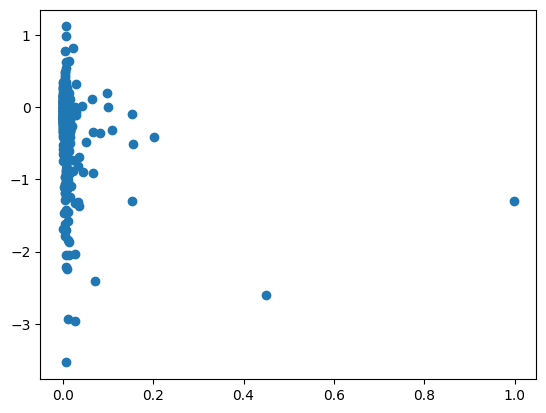

In [15]:
# Get diagonal of hat matrix (leverage)
leverage = np.diag(hat_matrix)

# Plot the leverage values
plt.scatter(leverage, y);

Para poder ver de mejora manera los leverage points vamos hacer un describe.

In [16]:
# get information to a pandas dataframe
leverage = pd.DataFrame(leverage)
leverage.describe()

,0
count,769.000000
mean,0.009103
std,0.041872
min,0.000000
25%,0.004009
50%,0.004659
75%,0.006123
max,0.997699


AHORA PODEMOS DECIR CON SEGURIDAD QUE HAY LEVERAGE POINTS POR LA GRÁFICA DE ARRIBA, POSTERIOR A ESTO PODEMOS SABE CUALES ELIMINAR A PARTIR DE LA REGLA DE DEDO QUE NOS DICE QUE 2(K+1)/N DONDE K ES EL NÚMERO DE VARIABLES (X) Y N EL NÚMERO DE OBSERVACIONES (SIZE) POR LO QUE AL APLICAR ESTA REGLA OBTENGO QUE:
- LOS DATOS DEBEN SER MENORES A *__2(7+1)/769 = 0.0208__* PARA NO SER CONSIDERADOS LEVERAGE POINS.

##### __Outliers__

Ahora vamos a identivicar los outliers con 2 métodos diferentes:

- __Cook's distance__
- __Standarized residuals__

Ahora con ayuda de los frameworks y el modelo obtenido anteriorment vamos a calcular el __Cook's distance__.

In [17]:
# Cook's - distance
influence = model1.get_influence()  # create instance of influence
(cooks, p) = influence.cooks_distance  # obtain Cook's distance for each observation

# get information to a pandas dataframe
cooks = pd.DataFrame(cooks)
cooks.describe()

,0
count,7.690000e+02
mean,2.242694e+00
std,6.210342e+01
min,1.414750e-09
25%,2.256836e-05
50%,9.099072e-05
75%,3.459171e-04
max,1.722184e+03


AHORA PODEMOS SABER CON SEGURIDAD GRACIAS AL ANÁLISIS DE COOK'S DISTANCE CUALES SON LOS OUTLIERS QUE TENEMOS EN NUESTRO DATOS. ESTO LOS CALCULAMOS CON EL PROMEDIO POR 3 QUE OBTENEMOS EN LA DESCRIPCIÓN DE ARRIBA __(2.242*3)__.

Ahora con ayuda de los frameworks y el modelo obtenido anteriorment vamos a calcular los __Standardized Residuals__.

In [18]:
# Standardized Residuals
influence = model1.get_influence()  # create instance of influence
standardized_residuals = influence.resid_studentized_internal  # obtain standardized residuals

# get information to a pandas dataframe
standardized_residuals = pd.DataFrame(standardized_residuals)
standardized_residuals.describe()


,0
count,769.000000
mean,0.007860
std,1.026092
min,-8.286463
25%,-0.200180
50%,0.169444
75%,0.466065
max,5.583984


CON EL ANÁLISIS DE STANDARDIZED RESIDUALES PODEMOS VER MÁS OUTLIER QUE SE ENCUENTRAN EN NUESTROS DATOS. SEGÚN LA LITERATURA, DEBEMOS TOMAR UN VALOR ABSOLUTO DE 3 PARA PODER SELECCIONAR ESOS DATOS COMO OUTLIERS Y DESCARTARLOS.

##### __Obteniendo outliers y leverage points__

In [40]:
# Checando outliers y leverage points
mask1 = abs(cooks[0]) > cooks[0].mean()*3
outlier1 = cooks[mask1]
outlier1

,0
68,1722.183772


In [41]:
mask2 = abs(standardized_residuals[0]) >= 3
outlier2 = standardized_residuals[mask2]
outlier2

,0
11,-3.052743
19,3.904181
28,-8.286463
30,-6.214112
68,5.583984
183,-3.358318
188,-3.850727
196,-6.021284
227,-4.329141
229,-3.279499


In [42]:
mask3 = abs(leverage[0]) > (2*(7+1)/769)
leverage_points = leverage[mask3]
leverage_points

,0
9,0.153851
14,0.035069
16,0.450698
19,0.154830
25,0.066920
27,0.071840
30,0.027169
68,0.997699
123,0.201797
135,0.022867


In [20]:
# Merge outliers and leverage to get most influential values
influential = pd.merge(leverage_points, outlier2, left_index=True, right_index=True)
influential

,0_x,0_y
19,0.154830,3.904181
30,0.027169,-6.214112
68,0.997699,5.583984
188,0.027147,-3.850727
229,0.022713,-3.279499


YA TENEMOS LOS VALORES MÁS INFLUENCIABLES PARA ELIMINAR, ENTONCES PROCEDEREMOS A SACAR DICHOS MATRICIALES DEL MODELO Y POSTERIO A ELLO GENERAMOS UN NUEVO MODELO CON LOS VALORES INFLUENCIABLES ELIMINARDOS.

### __Análisis de multicolinealidad__

In [21]:
# Calculate the multicolinearity
vif_data = pd.DataFrame()
vif  = us_firms2022[['EPSP', 'OPM', 'Book-to-market ratio', 'Short financial leverage', 'Long financial leverage', 'Small', 'Medium']]
vif_data["feature"] = vif.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(vif.values, i) for i in range(len(vif.columns))]
print(vif_data)

                    feature       VIF
0                      EPSP  1.075821
1                       OPM  1.004487
2      Book-to-market ratio  2.278923
3  Short financial leverage  1.038799
4   Long financial leverage  1.341008
5                     Small  1.647088
6                    Medium  1.587976


TRAS CALCULAR LA MULTICOLINEARIDAD PODEMOS OBSERVAR LA RELACIÓN QUE TIENEN NUESTRAS VARIABLES INDEPENDIENTES ENTRE ELLAS, AL TENER UN VALOR MENOR A 5, NOS DAMOS CUENTA DE QUE TODAS LAS VARIABLES SELECCIONADAS SON DE VALOR PARA REALIZAR NUESTRA PREDICCIÓN.

### __Estimación e interpretación un modelo de regresión múltiple__

#### __Estimación de coeficientes__

Para poder realizar el calculo de nuestros coeficientes usamos la siguiente formula:

- $ (X' \cdot X)^{-1} \cdot (X' \cdot y) $

In [22]:
# Calculate the betas by using the next formula:
# (X' . X)^-1 . X' . y
X['Ones'] = 1                 # Add a column of ones

X_trans = X.T                 # Transpose de X 
X_aux = X_trans @ X           # Make a dot product
X_inv = np.linalg.inv(X_aux)  # Calculate the inverse
X_again = X_inv @ X_trans     # Make a dot product
Betas = X_again @ y           # Make a dot product
print(Betas)

0    1.598568
1    0.001201
2   -0.110850
3   -0.887387
4   -0.193623
5   -0.077813
6   -0.023374
7   -0.042060
dtype: float64


#### __Estimación de errores estándar__

Para calcular los errores estándar uso el mean square error, aplicando la siguiente formula:

- $ \frac{1}{n} \sum_{i=1}^{n}(y_i-\hat{y}_i)^2 $

In [23]:
# Primero obtenemos los valores de R predecidos
y_pred = sum((Betas.to_numpy() * X.to_numpy()).T)

# Getting the mse
error = sum((y - y_pred)**2) / len(y)
error

0.15033808728585624

EN LA CELDA DE CÓDIGO ARRIBA, CALCULAMOS EL ERROR ESTÁNDAR DE NUESTRAS PREDICCIÓN, PARA ESTO CALCULAMOS EL VALOR DE NUESTROS Y'S PREDECIDOS Y LO RESTAMOS CON EL VALOR DE NUESTRA Y REAL, DANDONOS UN VALOR PROMEDIO DEL ERROR AL CUADRADO DE 0.15

### __Segundo modelo sacando valores influenciables (outliers y leverage points)__

ES NECESARIO ELIMINAR LOS DATOS INFLUECIABLES DEBIDO A QUE TERMINAN PERJUDICANDO EL FUNCIONAMIENTO DE NUESTRO MODELO[], PORQUE AL SER VARIABLES QUE SE SALEN DE LA TENDECIA AFECTAN AL RESTO DE LOS VALORES.

In [37]:
# Dropeamos puntos influenciables
X_new = X.copy()
y_new = y.copy()

X_new = X_new.drop(influential.index)
y_new = y_new.drop(influential.index)

Calculamos el modelo de regresión para ver cuanto mejora el modelo.

In [39]:
# Model statistics
model2 = sm.OLS(y_new, sm.add_constant(X_new)).fit()
print_model2 = model2.summary()
print(print_model2)

                            OLS Regression Results                            
Dep. Variable:                      R   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     32.82
Date:                Fri, 25 Nov 2022   Prob (F-statistic):           6.22e-40
Time:                        18:24:17   Log-Likelihood:                -313.42
No. Observations:                 764   AIC:                             642.8
Df Residuals:                     756   BIC:                             679.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
EPSP                    

CON LA ELIMINACIÓN DE LOS INFLUENCIABLES PODEMOS VER QUE EL SEGUNDO MODELO MEJORA EN UN 13% CON RESPECTO AL MODELO ANTERIOR (0.206 A 0.233).

Posteriormente calculamos nuestras betas con el uso de algebra matricial.

In [38]:
# Calculate the betas by using the next formula:
# (X' . X)^-1 . X' . y
Xnew_trans = X_new.T             # Transpose de X 
Xnew_aux = Xnew_trans @ X_new    # Make a dot product
X_inv = np.linalg.inv(Xnew_aux)  # Calculate the inverse
X_again = X_inv @ Xnew_trans     # Make a dot product
Betas = X_again @ y_new       # Make a dot product
print(Betas)

0    1.629361
1    0.051384
2   -0.105640
3   -0.818795
4   -0.135696
5   -0.056403
6   -0.026135
7   -0.080995
dtype: float64


PODEMOS COMPROBAR QUE EL CALCULO DE LAS BETAS ES CORRECTO DEBIDO A QUE LOS VALORES COINCIDEN CON LOS OBTENIDOS EN LA APLICACIÓN DEL NUEVO MODELO QUE HACE USO DE UN FRAMEWORK.